## 第三节：特征工程与基线模型

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm  

class _Data_Preprocess:
    def __init__(self):
        self.int8_max = np.iinfo(np.int8).max
        self.int8_min = np.iinfo(np.int8).min

        self.int16_max = np.iinfo(np.int16).max
        self.int16_min = np.iinfo(np.int16).min

        self.int32_max = np.iinfo(np.int32).max
        self.int32_min = np.iinfo(np.int32).min

        self.int64_max = np.iinfo(np.int64).max
        self.int64_min = np.iinfo(np.int64).min

        self.float16_max = np.finfo(np.float16).max
        self.float16_min = np.finfo(np.float16).min

        self.float32_max = np.finfo(np.float32).max
        self.float32_min = np.finfo(np.float32).min

        self.float64_max = np.finfo(np.float64).max
        self.float64_min = np.finfo(np.float64).min

    def _get_type(self, min_val, max_val, types):
        if types == 'int':
            if max_val <= self.int8_max and min_val >= self.int8_min:
                return np.int8
            elif max_val <= self.int16_max <= max_val and min_val >= self.int16_min:
                return np.int16
            elif max_val <= self.int32_max and min_val >= self.int32_min:
                return np.int32
            return None

        elif types == 'float':
            if max_val <= self.float16_max and min_val >= self.float16_min:
                return np.float16
            if max_val <= self.float32_max and min_val >= self.float32_min:
                return np.float32
            if max_val <= self.float64_max and min_val >= self.float64_min:
                return np.float64
            return None

    def _memory_process(self, df):
        init_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('Original data occupies {} GB memory.'.format(init_memory))
        df_cols = df.columns

          
        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except:
                print(' Can not do any process for column, {}.'.format(col)) 
        afterprocess_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('After processing, the data occupies {} GB memory.'.format(afterprocess_memory))
        return df

## 3.3 基线模型

### 3.3.1 数据读取

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 数据读取

In [3]:
path  = '../security_data/'
train = pd.read_csv(path + 'security_train.csv')
test  = pd.read_csv(path + 'security_test.csv')

In [4]:
train.head()

,file_id,label,api,tid,index
0,1,5,LdrLoadDll,2488,0
1,1,5,LdrGetProcedureAddress,2488,1
2,1,5,LdrGetProcedureAddress,2488,2
3,1,5,LdrGetProcedureAddress,2488,3
4,1,5,LdrGetProcedureAddress,2488,4


### 3.3.2 特征工程 

In [5]:
def simple_sts_features(df):
    simple_fea             = pd.DataFrame()
    simple_fea['file_id']  = df['file_id'].unique()
    simple_fea             = simple_fea.sort_values('file_id')
     
    df_grp = df.groupby('file_id')
    simple_fea['file_id_api_count']   = df_grp['api'].count().values
    simple_fea['file_id_api_nunique'] = df_grp['api'].nunique().values
    
    simple_fea['file_id_tid_count']   = df_grp['tid'].count().values
    simple_fea['file_id_tid_nunique'] = df_grp['tid'].nunique().values
    
    simple_fea['file_id_index_count']   = df_grp['index'].count().values
    simple_fea['file_id_index_nunique'] = df_grp['index'].nunique().values
    
    return simple_fea

In [6]:
%%time
simple_train_fea1 = simple_sts_features(train)

Wall time: 1.4 s


In [7]:
%%time
simple_test_fea1 = simple_sts_features(test)

Wall time: 23.9 ms


In [8]:
def simple_numerical_sts_features(df):
    simple_numerical_fea             = pd.DataFrame()
    simple_numerical_fea['file_id']  = df['file_id'].unique()
    simple_numerical_fea             = simple_numerical_fea.sort_values('file_id')
     
    df_grp = df.groupby('file_id')
    
    simple_numerical_fea['file_id_tid_mean']  = df_grp['tid'].mean().values
    simple_numerical_fea['file_id_tid_min']   = df_grp['tid'].min().values
    simple_numerical_fea['file_id_tid_std']   = df_grp['tid'].std().values
    simple_numerical_fea['file_id_tid_max']   = df_grp['tid'].max().values
    
    
    simple_numerical_fea['file_id_index_mean']= df_grp['index'].mean().values
    simple_numerical_fea['file_id_index_min'] = df_grp['index'].min().values
    simple_numerical_fea['file_id_index_std'] = df_grp['index'].std().values
    simple_numerical_fea['file_id_index_max'] = df_grp['index'].max().values
    
    return simple_numerical_fea

In [9]:
%%time
simple_train_fea2 = simple_numerical_sts_features(train)

Wall time: 172 ms


In [10]:
%%time
simple_test_fea2 = simple_numerical_sts_features(test)

Wall time: 18 ms


### 3.3.3 基线构建

In [11]:
train_label = train[['file_id','label']].drop_duplicates(subset = ['file_id','label'], keep = 'first')
test_submit = test[['file_id']].drop_duplicates(subset = ['file_id'], keep = 'first')

In [12]:
### 训练集&测试集构建
train_data = train_label.merge(simple_train_fea1, on ='file_id', how='left')
train_data = train_data.merge(simple_train_fea2, on ='file_id', how='left')

test_submit = test_submit.merge(simple_test_fea1, on ='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea2, on ='file_id', how='left')

In [14]:
def lgb_logloss(preds,data):
    labels_ = data.get_label()             
    classes_ = np.unique(labels_) 
    preds_prob = []
    for i in range(len(classes_)):
        preds_prob.append(preds[i*len(labels_):(i+1) * len(labels_)] )
        
    preds_prob_ = np.vstack(preds_prob) 
    
    loss = []
    for i in range(preds_prob_.shape[1]):     # 样本个数
        sum_ = 0
        for j in range(preds_prob_.shape[0]): #类别个数
            pred = preds_prob_[j,i]           # 第i个样本预测为第j类的概率
            if  j == labels_[i]:
                sum_ += np.log(pred)
            else:
                sum_ += np.log(1 - pred)
        loss.append(sum_)       
    return 'loss is: ',-1 * (np.sum(loss) / preds_prob_.shape[1]),False

In [15]:
### 模型验证
train_features = [col for col in train_data.columns if col not in ['label','file_id']]
train_label    = 'label'

In [16]:
%%time
from sklearn.model_selection import StratifiedKFold,KFold
params = {
        'task':'train', 
        'num_leaves': 255,
        'objective': 'multiclass',
        'num_class': 8,
        'min_data_in_leaf': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5, 
        'max_bin':128,
        'random_state':100
    }   

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][train_features], label=train_data.iloc[trn_idx][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_idx][train_features], label=train_data.iloc[val_idx][train_label].values) 
    
    clf = lgb.train(params, trn_data, num_boost_round=2000,valid_sets=[trn_data,val_data], verbose_eval=50, early_stopping_rounds=100, feval=lgb_logloss) 
    models.append(clf)

fold n°0
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
[100]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
fold n°1
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109
[100]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109

In [17]:
%%time
from sklearn.model_selection import StratifiedKFold,KFold
params = {
        'task':'train', 
        'num_leaves': 255,
        'objective': 'multiclass',
        'num_class': 8,
        'min_data_in_leaf': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5, 
        'max_bin':128,
        'random_state':100
    }   

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][train_features], label=train_data.iloc[trn_idx][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_idx][train_features], label=train_data.iloc[val_idx][train_label].values) 
    
    clf = lgb.train(params, trn_data, num_boost_round=2000,valid_sets=[trn_data,val_data], verbose_eval=50, early_stopping_rounds=100, feval=lgb_logloss) 
    models.append(clf)

fold n°0
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
[100]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.83717	training's loss is: : 2.41456	valid_1's multi_logloss: 1.28536	valid_1's loss is: : 0.941228
fold n°1
Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109
[100]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.77226	training's loss is: : 2.32838	valid_1's multi_logloss: 2.10695	valid_1's loss is: : 1.86109

### 3.3.4 特征重要性分析

In [18]:
feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp']  = clf.feature_importance()
feature_importance             = feature_importance.sort_values('fea_imp',ascending = False)

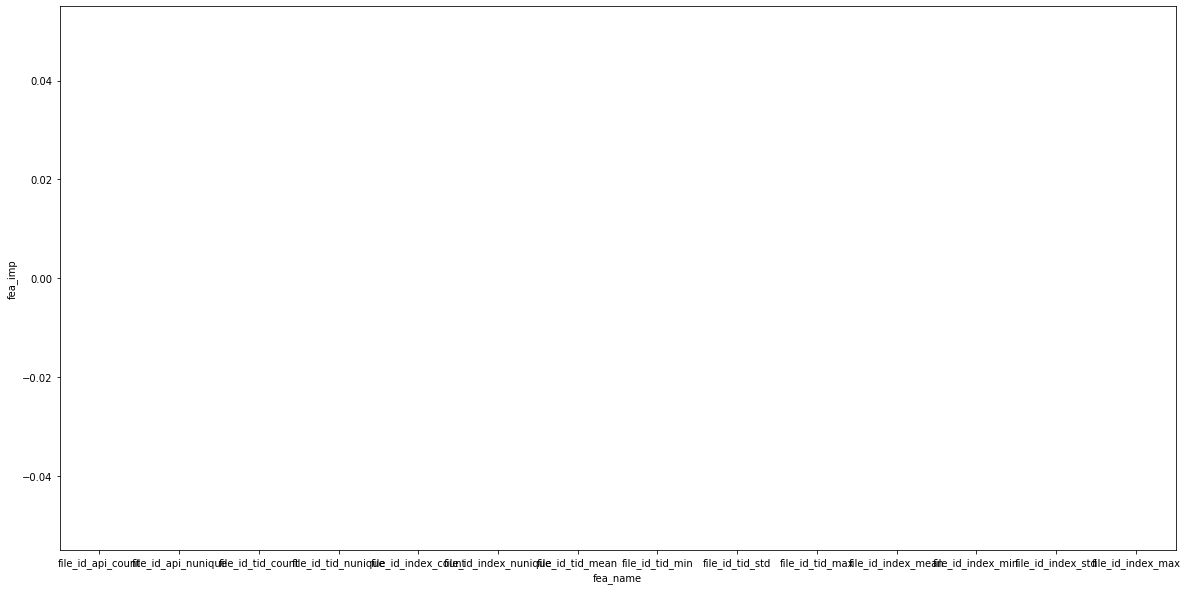

In [19]:
plt.figure(figsize=[20, 10,])
sns.barplot(x = feature_importance['fea_name'], y = feature_importance['fea_imp'])
#sns.barplot(x="fea_name",y="fea_imp",data=feature_importance)

### 3.3.5 模型测试

In [20]:
pred_res = 0
fold = 5
for model in models:
    pred_res +=model.predict(test_submit[train_features]) * 1.0 / fold 

In [21]:
test_submit['prob0'] = 0
test_submit['prob1'] = 0
test_submit['prob2'] = 0
test_submit['prob3'] = 0
test_submit['prob4'] = 0
test_submit['prob5'] = 0
test_submit['prob6'] = 0
test_submit['prob7'] = 0

In [22]:
test_submit[['prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']] = pred_res
test_submit[['file_id','prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']].to_csv('baseline.csv',index = None)